In [72]:
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize, LinearConstraint

import matplotlib.pyplot as plt
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from collections import defaultdict

np.random.seed(42)


In [3]:
"""
necessary considerations:
- if the risk aversion is too high, the short selling should be forbidden (add to constraint). 
- may be I should also check if the historical data is enough to calculate if the user ask for a long period. (Function: efficient_frontier_series)
- check the format of the input data (efficient_frontier_series: history_start).
"""

'\nnecessary considerations:\n- if the risk aversion is too high, the short selling should be forbidden (add to constraint). \n- may be I should also check if the historical data is enough to calculate if the user ask for a long period. (Function: efficient_frontier_series)\n- check the format of the input data (efficient_frontier_series: history_start).\n'

In [4]:
app = Flask(__name__)

In [95]:
# for calculation
def utility_function(weights, mean_returns, cov_matrix, risk_aversion):
    """Utility function to minimize."""
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(returns - 0.5 * risk_aversion * risk ** 2)

def optimal_portfolio(mean_returns, cov_matrix, risk_aversion, short_sales):
    """Calculate optimal portfolio."""
    num_assets = len(mean_returns)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    constraints = LinearConstraint(np.ones(num_assets), 1, 1)
    bounds = None if short_sales else [(0, 1)] * num_assets 

    best_result = None
    best_utility = float('-inf')

    initial_guesses = [
        np.ones(num_assets) / num_assets,  # Equal weights
        np.random.random(num_assets),      # Random weights
    ]
    for init_guess in initial_guesses:
        # Normalize the initial guess to sum to 1
        if np.sum(init_guess) != 0:
            init_guess = init_guess / np.sum(init_guess)
        else:
            init_guess = np.ones(num_assets) / num_assets
            
        opt = minimize(utility_function, init_guess, args=(mean_returns, cov_matrix, risk_aversion),
                       bounds=bounds, constraints=constraints, method='trust-constr')
        
        if opt.success:
            utility = -utility_function(opt.x, mean_returns, cov_matrix, risk_aversion)
            if best_result is None or utility > best_utility:
                best_result = opt.x
                best_utility = utility
    
    if best_result is not None:
        return best_result
    else:
        print("Optimization failed for all initial guesses")
        return np.ones(num_assets) / num_assets

def efficient_frontier(avg_returns, cov_matrix, short_sales):
    """Calculate efficient frontier."""
    num_assets = len(avg_returns)
    result = []
    for target_return in np.linspace(min(avg_returns), max(avg_returns), 50):
        def objective(weights):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, avg_returns) - target_return}
        ]
        bounds = None if short_sales else [(0, 1)] * num_assets 
        init_guess = np.ones(num_assets) / num_assets  
        opt = minimize(objective, init_guess, bounds=bounds, constraints=constraints)
        if opt.success:
            result.append([target_return, opt.fun])
    return np.array(result) if result else np.array([]).reshape(0, 2)

def efficient_frontier_series(fund_data, risk_aversion, history_start = (pd.Timestamp(datetime.now()) - relativedelta(months=1)).normalize(), 
                              backtest_period_month=12, short_sales=True, risk_free_rate = 0.02):
    """Calculate efficient frontier for a series of backtest periods."""
    
    """
    history_start: str or pd.Timestamp
        Available start date for the user check his optimal portfolio at that day.
    backtest_period_month: int
        Number of months for backtest period. i.e. the period that we calculate the efficient frontier and optimal portfolio.
    """
    
    # Initialize variables
    if history_start:
        if not isinstance(history_start, pd.Timestamp):  
            if isinstance(history_start, str):  
                history_start = pd.Timestamp(datetime.strptime(history_start, '%Y-%m-%d'))

    backtest_period = relativedelta(months=backtest_period_month)
    start_date = fund_data.index[0]
    end_date = fund_data.index[-1]
    results = defaultdict(dict)
    
    # Loop through backtest periods
    start_date = history_start - backtest_period
    while start_date + backtest_period < end_date:
        # Filter data
        data = fund_data[(fund_data.index >= start_date) & (fund_data.index < start_date + backtest_period)]
        returns = data.pct_change().dropna().T.values
        avg_returns = np.mean(returns, axis=1)
        cov_matrix = np.cov(returns)
        cov_matrix += np.eye(len(cov_matrix)) * 1e-6 # Add small value to diagonal for numerical stability

        # print(avg_returns)
        # print(cov_matrix)
        # Calculate efficient frontier
        frontier = efficient_frontier(avg_returns, cov_matrix, short_sales)
        optimal_portfolio_weights = optimal_portfolio(avg_returns, cov_matrix, risk_aversion, short_sales)
        results[start_date.strftime('%Y-%m-%d')]['frontier'] = frontier
        results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_weights'] = optimal_portfolio_weights
        results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_return_annual'] = np.dot(optimal_portfolio_weights, avg_returns) * 252
        results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_risk_annual'] = np.sqrt(np.dot(optimal_portfolio_weights.T, np.dot(cov_matrix, optimal_portfolio_weights))) * np.sqrt(252)
        results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_sharpe_annual'] = (results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_return_annual'] - risk_free_rate) / results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_risk_annual']
        # results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_return'] = np.dot(optimal_portfolio_weights, avg_returns)
        # results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_risk'] = np.sqrt(np.dot(optimal_portfolio_weights.T, np.dot(cov_matrix, optimal_portfolio_weights)))
        # results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_sharpe'] = (results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_return'] - risk_free_rate/252) / results[start_date.strftime('%Y-%m-%d')]['optimal_portfolio_risk']
        results[start_date.strftime('%Y-%m-%d')]['original_data_return_daily'] = avg_returns
        results[start_date.strftime('%Y-%m-%d')]['original_data_cov_daily'] = cov_matrix
        # print(results)

        # Update start date
        start_date += relativedelta(days=1)
    
    return results


In [19]:
# Initial parameters

# Fund tickers (replace with actual tickers if available)
fund_tickers = [
    "0P00011STA.SI", "0P0001JJ08.SI", "0P0001I4B6.SI", "0P0000Y077.SI",
    "0P0000Y35A", "0P0000K7H9", "0P0000TJCX", "0P00000DS2",
    "0P000019D5", "0P00008SN2.F"
]

# Download fund data from Yahoo Finance
fund_data = yf.download(fund_tickers, period="3y", interval="1d")['Close']
fund_data = fund_data.interpolate()
fund_data

[*********************100%***********************]  10 of 10 completed


Ticker,0P00000DS2,0P000019D5,0P00008SN2.F,0P0000K7H9,0P0000TJCX,0P0000Y077.SI,0P0000Y35A,0P00011STA.SI,0P0001I4B6.SI,0P0001JJ08.SI
Date,,,,,,,,,,
2022-03-21,NaN,NaN,371.899994,NaN,NaN,8.533051,NaN,NaN,8.799004,6.403750
2022-03-22,427.619995,44.860001,373.450012,228.210007,109.230003,8.523973,81.696533,15.956000,8.789521,6.438458
2022-03-23,424.350006,44.790001,367.369995,224.029999,109.230003,8.533051,81.836830,15.951000,8.780042,6.473167
2022-03-24,423.350006,44.709999,371.510010,226.610001,109.235001,8.523973,81.677818,15.974000,8.799004,6.464490
2022-03-25,428.519989,45.310001,372.410004,227.589996,109.239998,8.496739,81.331726,15.997000,8.808485,6.481844
...,...,...,...,...,...,...,...,...,...,...
2025-03-17,541.169983,57.610001,380.250000,304.350006,124.110001,8.420000,80.330002,20.997000,8.053700,5.920000
2025-03-18,539.659973,57.299999,376.720001,304.079987,124.129997,8.430000,81.010002,20.937000,8.048700,5.920000
2025-03-19,540.140015,57.560001,382.089996,306.739990,124.150002,8.440000,81.059998,21.118999,8.058100,5.920000


In [25]:
results = efficient_frontier_series(fund_data, risk_aversion=2, backtest_period_month=24)
"""
results structure:
{
    '2021-01-01': {
        'frontier': np.array,
        'optimal_portfolio_weights': np.array,
        'optimal_portfolio_return_annual': float,
        'optimal_portfolio_risk_annual': float,
        'optimal_portfolio_sharpe_annual': float,
        'original_data_return_daily': np.array,
        'original_data_cov_daily': np.array
    },
    ...
}
The key is the start date of the backtest period
Backtest_period_month is the number of months for backtest period defined in efficient_frontier_series function.
"""

"\nresults structure:\n{\n    '2021-01-01': {\n        'frontier': np.array,\n        'optimal_portfolio_weights': np.array,\n        'optimal_portfolio_return_annual': float,\n        'optimal_portfolio_risk_annual': float,\n        'optimal_portfolio_sharpe_annual': float,\n        'original_data_return_daily': np.array,\n        'original_data_cov_daily': np.array\n    },\n    ...\n}\nThe key is the start date of the backtest period\nBacktest_period_month is the number of months for backtest period defined in efficient_frontier_series function.\n"

In [ ]:
# Compute daily returns
returns = fund_data.pct_change().dropna().T.values

# Compute the average return for each fund
avg_returns = np.mean(returns, axis=1)

# Compute the variance-covariance matrix of returns
cov_matrix = np.cov(returns)

# Compute standard deviations
std_devs = np.sqrt(np.diag(cov_matrix))

# Risk-free rate assumption
risk_free_rate = 0.02 / 252  # Annualized 2% converted to daily

# Compute Sharpe ratios
sharpe_ratios = (avg_returns - risk_free_rate) / std_devs

@app.route('/efficient_frontier', methods=['GET']) # ?short_sales=true/false
def get_efficient_frontier():
    short_sales = request.args.get('short_sales', 'true').lower() == 'true'
    frontier = efficient_frontier(short_sales=short_sales)
    return jsonify({"efficient_frontier": frontier.tolist()})

@app.route('/fund_statistics', methods=['GET'])
def get_fund_statistics():
    statistics = []
    for i, ticker in enumerate(fund_tickers):
        statistics.append({
            "fund": ticker,
            "average_return": avg_returns[i],
            "standard_deviation": std_devs[i],
            "sharpe_ratio": sharpe_ratios[i]
        })
    return jsonify({"fund_statistics": statistics})

if __name__ == '__main__':
    app.run(debug=True)


## Check

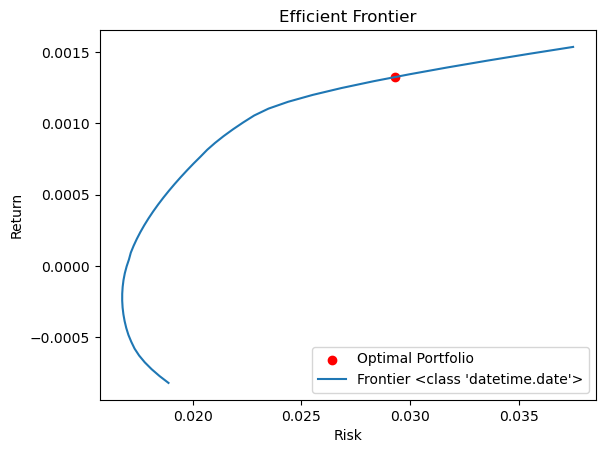

In [101]:
import numpy as np

mean_ret = np.array([0.000809093, 0.001537579, 0.000131069, 0.000972346, -0.000822326])

var_cov = np.array([
    [0.001233218, 0.00103242,  0.000416153, 0.000623291, 0.000250602],
    [0.00103242,  0.001406172, 0.000317927, 0.000508075, 0.000114722],
    [0.000416153, 0.000317927, 0.00043128,  0.000291777, 0.000194576],
    [0.000623291, 0.000508075, 0.000291777, 0.000499092, 0.000207857],
    [0.000250602, 0.000114722, 0.000194576, 0.000207857, 0.000356763]
])
short_sales = False
frontier  = efficient_frontier(mean_ret, var_cov, short_sales=short_sales)
optimal_portfolio_weights = optimal_portfolio(mean_ret, var_cov, 1, short_sales=short_sales)
port_ret = np.dot(optimal_portfolio_weights, mean_ret) 
port_var = np.sqrt(np.dot(optimal_portfolio_weights.T, np.dot(var_cov, optimal_portfolio_weights)))
plt.scatter(port_var, port_ret, color='red', label='Optimal Portfolio')
plt.plot(frontier[:, 1], frontier[:, 0], label=f'Frontier {date}')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

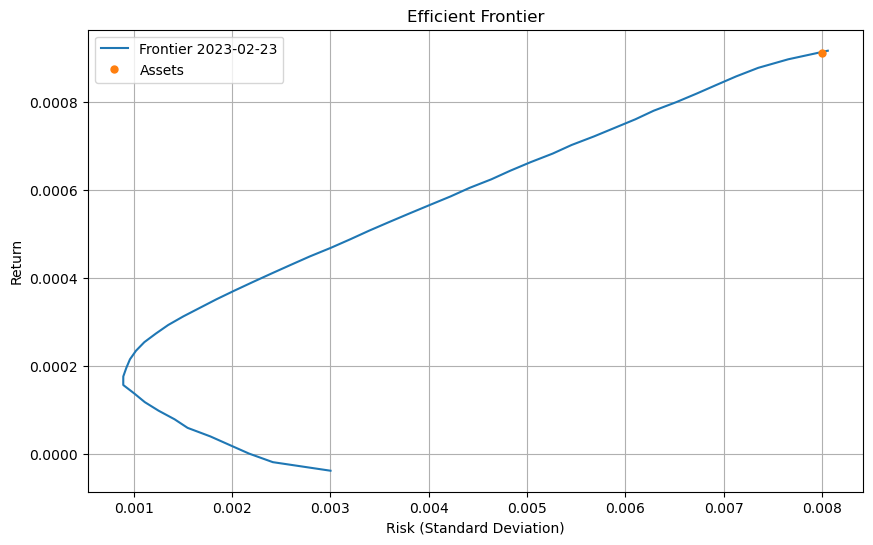

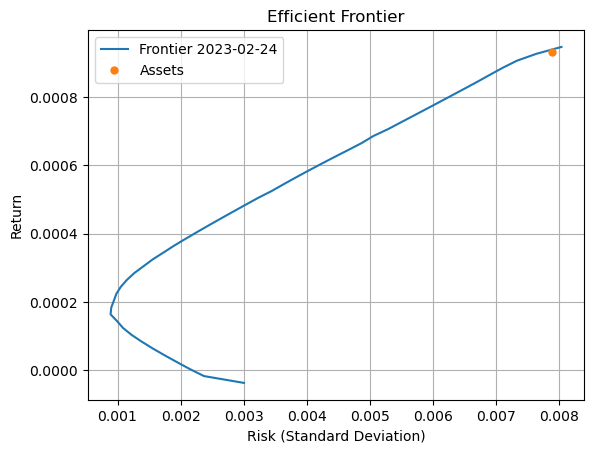

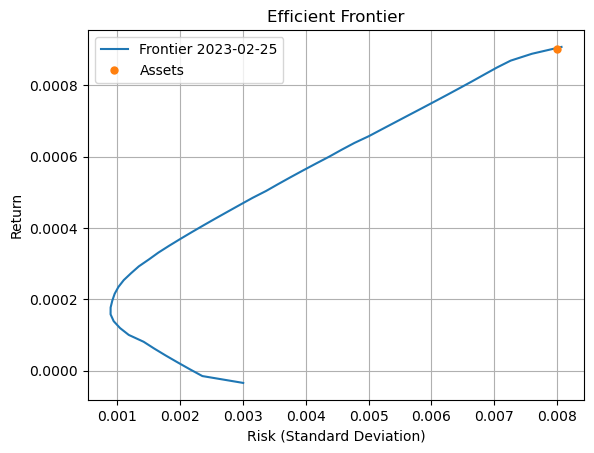

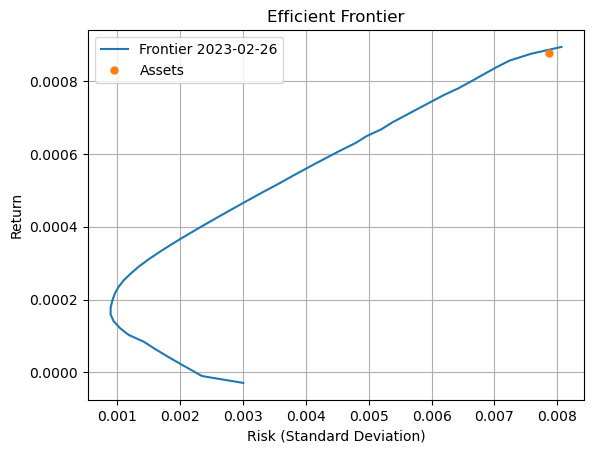

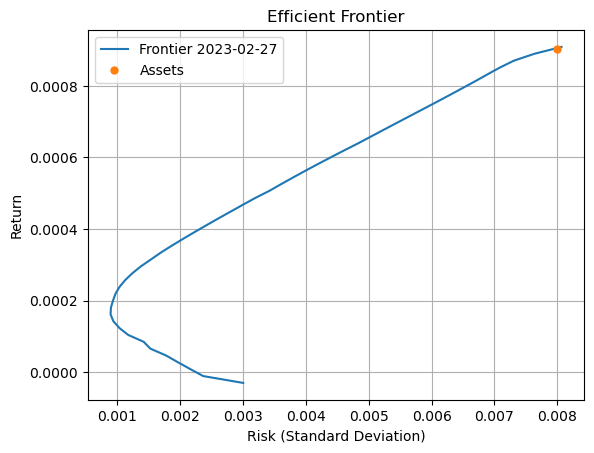

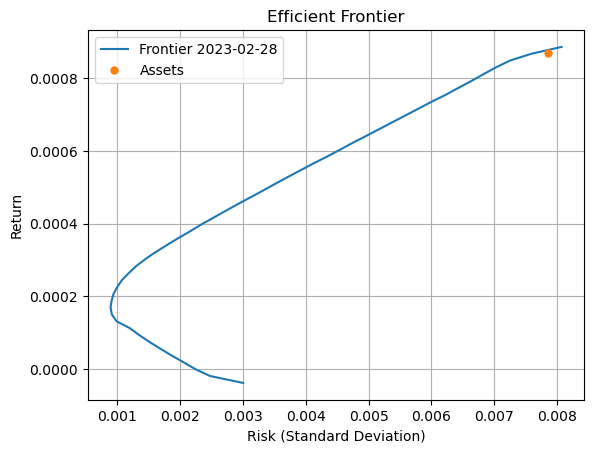

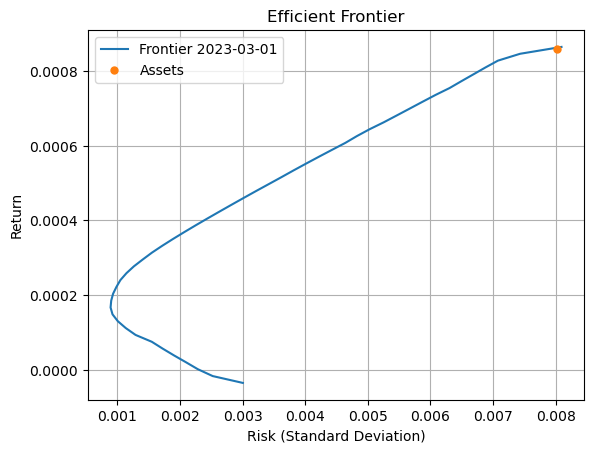

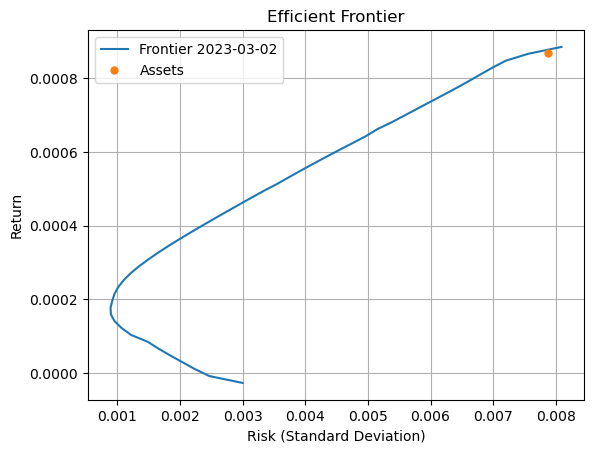

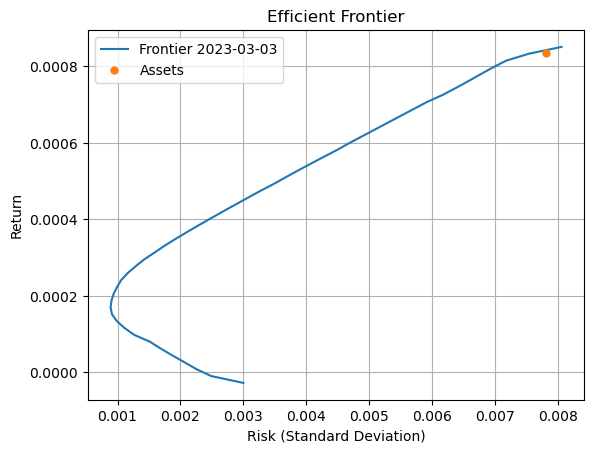

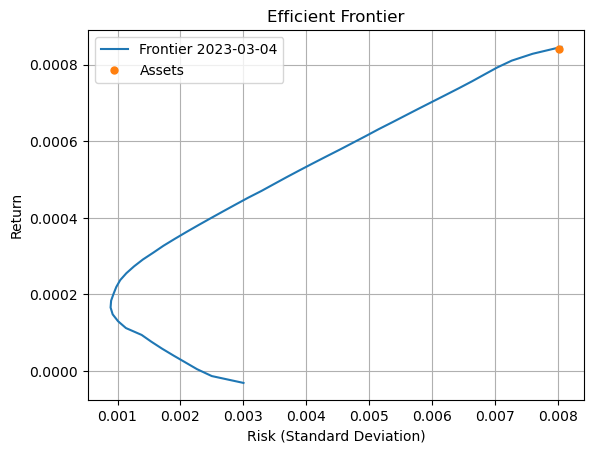

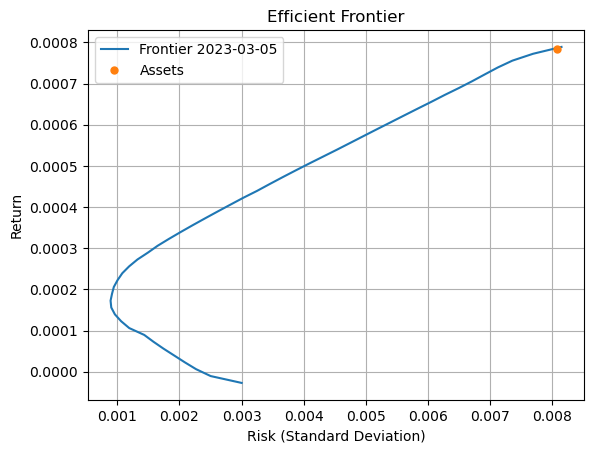

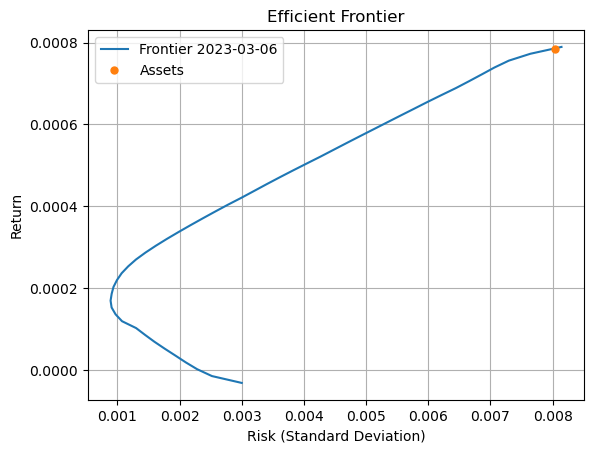

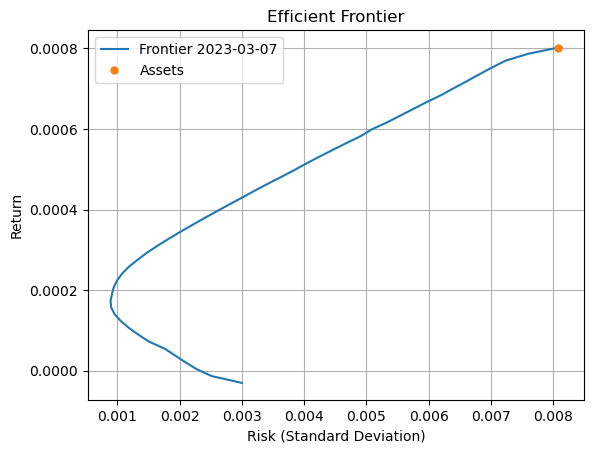

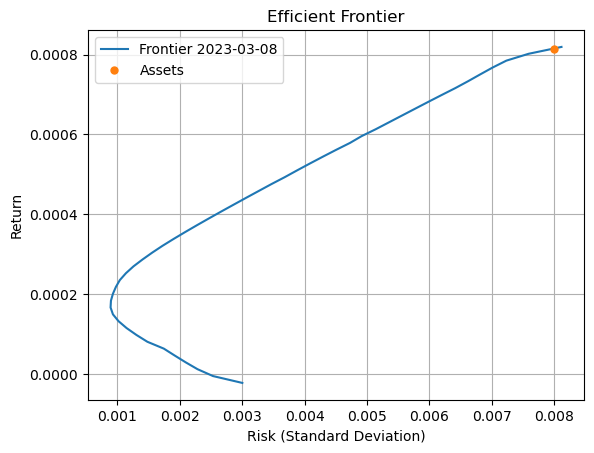

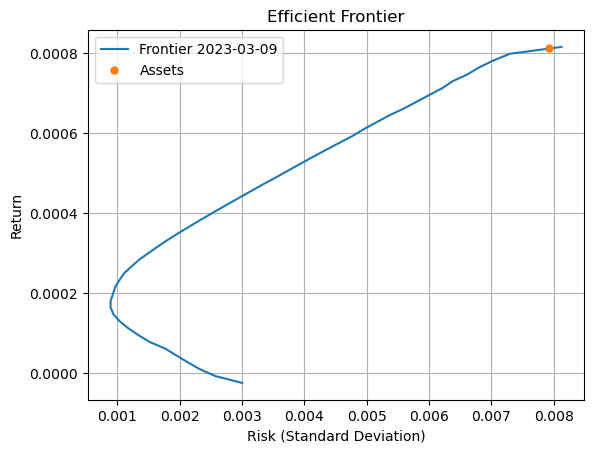

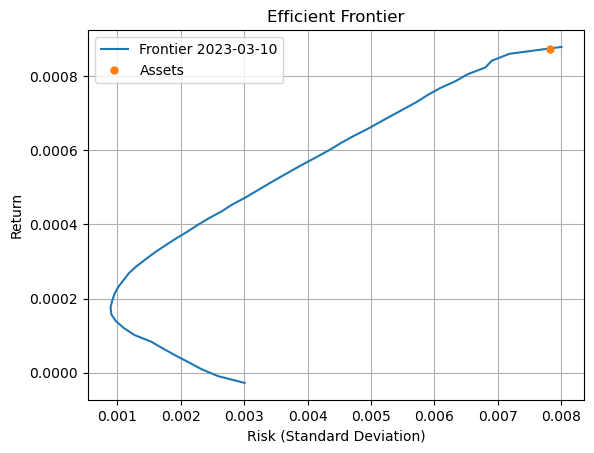

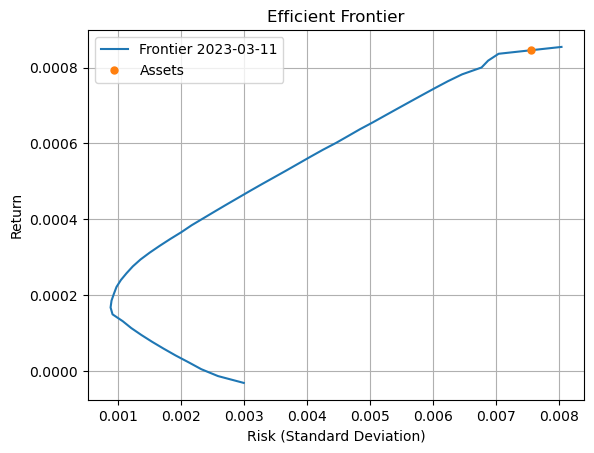

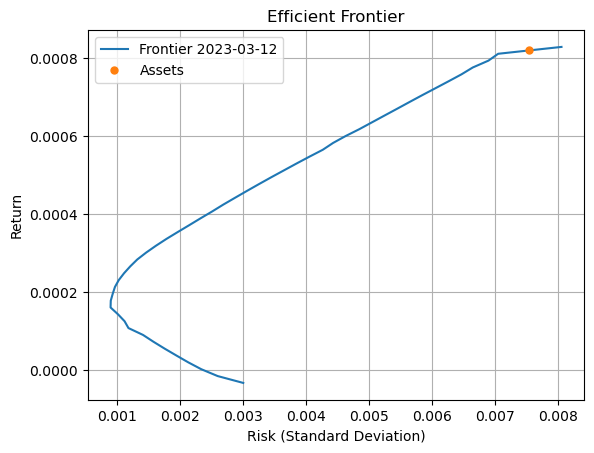

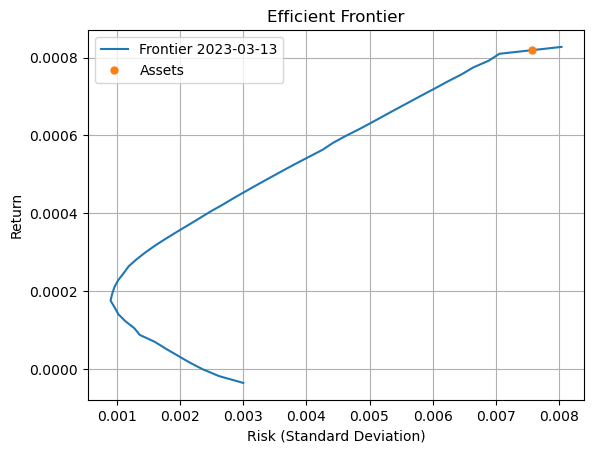

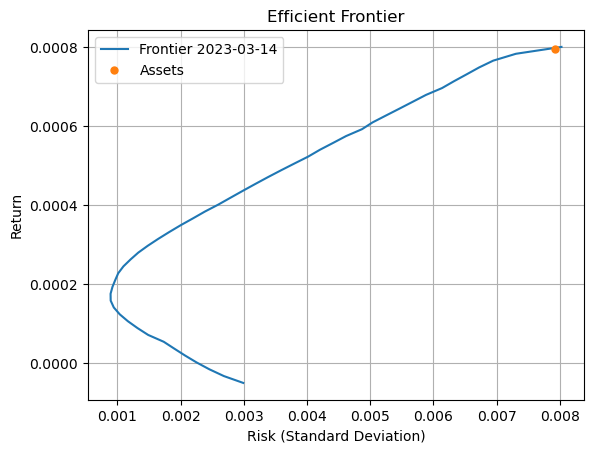

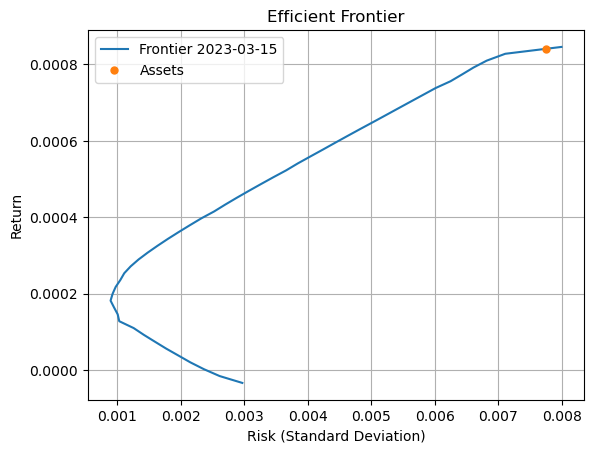

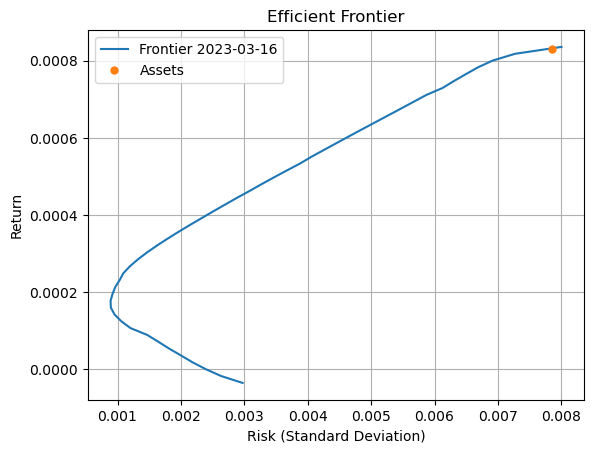

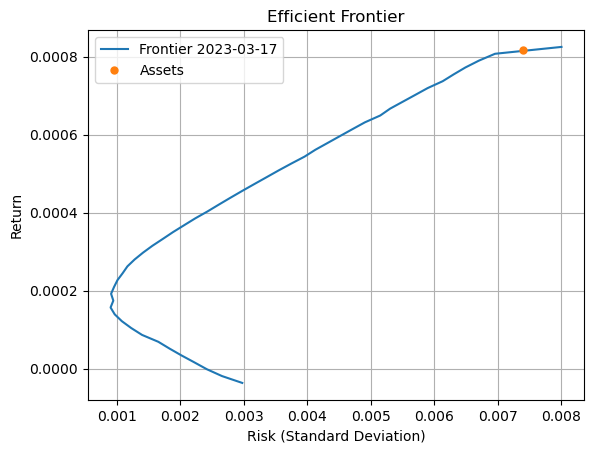

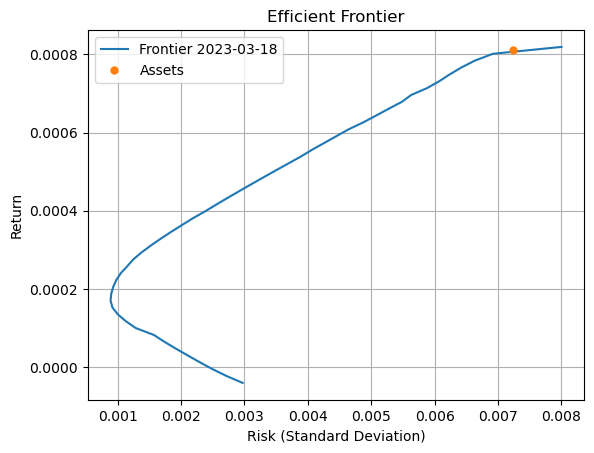

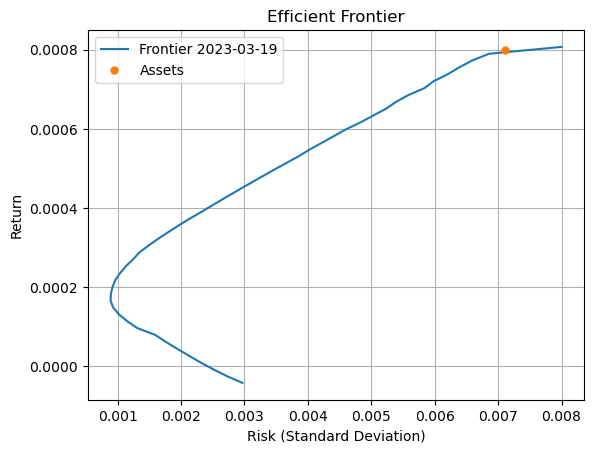

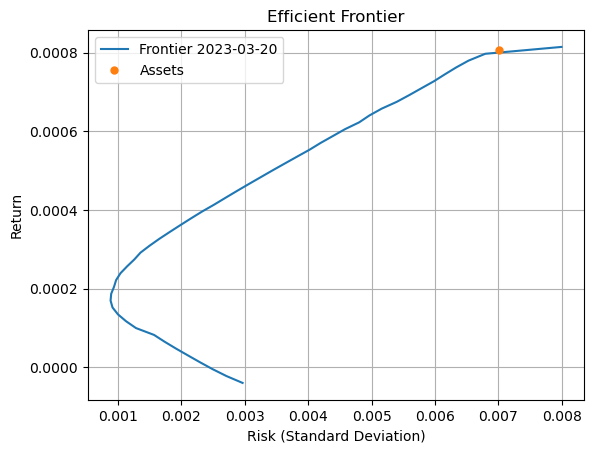

In [102]:
# Visualize the optimal portfolio and its efficient frontier
def plot_efficient_frontier(results):
    plt.figure(figsize=(10, 6))
    
    for date, data in results.items():
        frontier = data['frontier']
        if frontier.size > 0:
            plt.plot(frontier[:, 1], frontier[:, 0], label=f'Frontier {date}')
            plt.plot(data['optimal_portfolio_risk_annual']/np.sqrt(252), data['optimal_portfolio_return_annual']/252, 'o', markersize=5, label='Assets')
    
            plt.xlabel('Risk (Standard Deviation)')
            plt.ylabel('Return')
            plt.title('Efficient Frontier')
            plt.legend()
            plt.grid(True)
            plt.show()

# Plot the efficient frontier
results = efficient_frontier_series(fund_data, risk_aversion=2, backtest_period_month=24, short_sales=False)
plot_efficient_frontier(results)